In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


import sys
import importlib
sys.path.append('../../helpers/')
import helper
# sys.path.append('../../model/')
# from modified_emb_model import Classifier, train, test

In [2]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is not available, using CPU instead


In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_val = pd.read_csv('./data/validation.csv')

In [4]:
print(len(df_train.columns))
df_train.columns

10


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

In [5]:
def categorize_columns(dataframe):
    categorical_columns = []
    continuous_columns = []
    unique_classes_per_column = []  # To hold the number of unique classes for each categorical column

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object' or len(dataframe[column].unique()) <= 10:
            # If the column's data type is 'object' or it has 10 or fewer unique values, consider it categorical.
            categorical_columns.append(column)
            unique_classes_per_column.append(dataframe[column].nunique())  # Store the number of unique classes
        else:
            # Otherwise, consider it continuous.
            continuous_columns.append(column)

    # Calculate the total number of unique classes across all categorical columns.
    total_unique_classes = sum(dataframe[col].nunique() for col in categorical_columns)

    return categorical_columns, continuous_columns, total_unique_classes, unique_classes_per_column


cat_cols, cont_cols, total_unique, unique_classes_per_column = categorize_columns(df_train)
print(cat_cols)
print(cont_cols)
print(total_unique)
print(unique_classes_per_column)

['ocean_proximity']
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
5
[5]


In [6]:
df_train['ocean_proximity'].value_counts()

ocean_proximity
0.0    5423
1.0    3898
4.0    1558
3.0    1378
2.0       2
Name: count, dtype: int64

In [7]:
class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.int64).values

        self.x = df.drop(task1_column, axis=1).astype(np.float32).values

   

    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        features = self.x[idx]
        labels_task1 = self.task1_labels[idx]

        return features, labels_task1
        # return self.x[index], self.task1_labels[index], self.task2_labels[index]

train_dataset = SingleTaskDataset(df_train, 'median_house_value')
val_dataset = SingleTaskDataset(df_val, 'median_house_value')
test_dataset = SingleTaskDataset(df_test, 'median_house_value')

batch_size = 32

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class CatNumTaskDataset(Dataset):
    def __init__(self, df: pd.DataFrame, task1_column, categorical_columns, numerical_columns):
        self.n = df.shape[0]
        self.task1_labels = df[task1_column].astype(np.float32).values
        
        # Extract categorical and numerical features
        self.x_categ = df[categorical_columns].astype(np.int64).values
        self.x_numer = df[numerical_columns].astype(np.float32).values

    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels
        categ_features = self.x_categ[idx]
        numer_features = self.x_numer[idx]
        labels_task1 = self.task1_labels[idx]

        return categ_features, numer_features, labels_task1
    
# determine cont and cat columns
cat_cols, cont_cols, num_unique_cats, unique_classes_per_column = categorize_columns(df_train)
    
train_dataset = CatNumTaskDataset(df_train, 'median_house_value', cat_cols, cont_cols)
val_dataset = CatNumTaskDataset(df_val, 'median_house_value', cat_cols, cont_cols)
test_dataset = CatNumTaskDataset(df_test, 'median_house_value', cat_cols, cont_cols)

batch_size = 64

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
print(unique_classes_per_column)

[5]


### Model init

In [11]:
num_features =  9
num_targets =   1
classes_per_target = [0] # 0 for single target regression task

print(f"Features: {num_features}")
print(f"Targets: {num_targets}")
print(f"Classes per Target: {classes_per_target}")

Features: 9
Targets: 1
Classes per Target: [0]


In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_cat_features, n_cont_features, num_target_labels, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_cont_features)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont_features)])

        self.cat_embeddings = nn.ModuleList(nn.Embedding(num_embeddings=n_cat_features[_], embedding_dim=embed_size) for _ in range(len(n_cat_features)))

        # Classifcation Embeddings for each target label
        # the way we embed the target labels seems unecessary. The nn.Embedding does a lot of extra work to create a simple
        # learnable embedding
        self.target_label_embeddings = nn.ModuleList([nn.Linear(in_features=1, out_features=embed_size) for _ in range(num_target_labels)])


    def forward(self, x_cat, x_cont):
        # print(x_cat)
        # print(x_cat.unsqueeze(2))
        # print(x_cont)
        # print(x_cont.unsqueeze(2))
        x_cat = x_cat.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        x_cont = x_cont.unsqueeze(2)

        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x_cont[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x_cont = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.cont_embeddings):
            # print(x_cont.shape)
            goin_in = x_cont[:,i,:]
            goin_out = e(goin_in)
            # print(f'cont going out : {goin_out.shape}')
            embeddings.append(goin_out)

        # for i, e in enumerate(self.cat_embeddings):
        #     # print(x_cat.shape)
        #     goin_in = x_cat[:,i,:]
        #     # print(f' in: {goin_in.shape}')

        #     # the nn.Embeding module returns shape [bs, i, emb_dim] to allow accessing these embeddigns by an index
        #     # I am assuming that we don't need to indecies, just the embeddings so I flatten

        #     goin_out = e(goin_in) 
        #     # print(f'cat going out : {goin_out}')
        #     embeddings.append(goin_out.squeeze(1))
        
        for i, e in enumerate(self.cat_embeddings):
            goin_in = x_cat[:, i, :]
            goin_out = e(goin_in)
            # print(f' cat going out: {goin_out.squeeze(1).shape}')
            embeddings.append(goin_out.squeeze(1))

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x_cat.device)
            temp = e(input)
            temp = temp.repeat(x_cat.size(0), 1)
            # temp = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)
        
        # class_embed = self.classification_embedding(torch.tensor([0], device=x.device))  # use index 0 for the classification embedding
        # class_embed = class_embed.repeat(x.size(0), 1) # -> (batch_size, embed_size)
        # class_embed = class_embed.unsqueeze(1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context

class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        # self.lin2 = nn.Linear(2*self.input, 2*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x
    
class regressionHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_regression):
        super(regressionHead, self).__init__()
        
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_regression * self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_regression * self.input, self.input)
        self.lin3 = nn.Linear(self.input, 1)  # Output layer for regression (single output)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): # the initialization
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin2.bias)

    def forward(self, x):
        x = torch.reshape(x, (-1, self.input))
        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)

        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)

        x = self.lin3(x) 

        # print(f' x: {x}')
        return x    


# DEFAULT PARAMETERS SET UP FOR MY DATASET. BE CAREFUL AND MAKE SURE YOU SET THEM UP HOW YOU WANT.
# All dropout is initially turned off
class Classifier(nn.Module):
    def __init__(self, 
                 rff_on = False,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_cat_features=66, # YOU WILL PROBABLY NEED TO CHANGE
                 n_cont_features=2, # YOU WILL PROBABLY NEED TO CHANGE
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4, #widens the mlp in the classification heads
                 targets_classes : list= [0] #[12,2] #put the number of classes in each target variable. traffic type = 3 classes, application type = 8 classes
                 ):
        super(Classifier, self).__init__()

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, embedding_dropout=embedding_dropout, n_cat_features=n_cat_features, n_cont_features=n_cont_features, num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([regressionHead(embed_size=embed_size, dropout=classification_dropout, mlp_scale_regression=mlp_scale_classification)])
        
    def forward(self, x_cat, x_num):
        
        class_embed, context = self.embeddings(x_cat, x_num)
        


        
        
        
        ########################
        
        # class_embed, context = self.embeddings(x)
        # print(f'class embed: {class_embed.shape}')
        # print(f'x before decode: {context.shape}')
        # print(f' cross w/ : {class_embed.shape}')
        x = self.decoder(class_embed, context)
        # print(f'x after decode: {x.shape}')
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            # print(f'x: {x.shape}')
            input = x[:, i,:]
            # print(f'input: {input.shape}')
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw


# Training and Testing Loops
# Should not need modification
def train(dataloader, model, loss_functions : list, optimizer, device_in_use):
  total_loss = 0
  target_count = len(loss_functions)

  total_correct = [0] * target_count
  total_samples = [0] * target_count
  all_targets   = [[] for _ in range(target_count)]
  all_predictions = [[] for _ in range(target_count)]
  y_pred_softmax = [0] * target_count
  y_pred_labels = [0] * target_count
  accuracy = []

  model.train()

  for (x_num, x_cat, targets) in dataloader:
      
    x_cat, x_num, targets = x_cat.to(device_in_use), x_num.to(device_in_use), targets.float().to(device_in_use)
    task_predictions = model(x_num, x_cat) #contains a list of the tensor outputs for each task

    # print('preds')
    # print(task_predictions[0].squeeze().shape)
    # # print(task_predictions[0].squeeze())

    # print('targ')
    # print(targets.shape)
    # print(targets)

    loss = 0


    loss += loss_functions[0](task_predictions[0], targets)
    loss = loss/len(loss_functions)
    total_loss+= loss.item() #just summing the two losses
    
    mse_1 = ((task_predictions[0] - targets)**2).mean()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  #Loss
  avg_loss = total_loss/len(dataloader)
  #Accuracies
  


  return avg_loss, mse_1





def test(dataloader, model, loss_functions : list, device_in_use):
  total_loss = 0
  target_count = len(loss_functions)
  total_correct = [0] * target_count
  total_samples = [0] * target_count
  all_targets   = [[] for _ in range(target_count)]
  all_predictions = [[] for _ in range(target_count)]
  y_pred_softmax = [0] * target_count
  y_pred_labels = [0] * target_count
  accuracy = []
  f1       = []

  model.eval()

  with torch.no_grad():
    for (x_num, x_cat, targets) in dataloader:
      x_cat, x_num, targets = x_cat.to(device_in_use), x_num.to(device_in_use), targets.float().to(device_in_use)

      task_predictions = model(x_num, x_cat) #contains a list of the tensor outputs for each task
      

      loss = 0
      for i in range(len(loss_functions)):
        loss += loss_functions[0](task_predictions[0], targets)
    #   loss = loss/len(loss_functions)
    #   print(loss)
      total_loss+= loss.item()

      mse_1 = ((task_predictions[0] - targets)**2).mean()

  #Loss
  avgloss = total_loss/len(dataloader)
 
  #Recall
  # recall = recall_score(all_targets, all_predictions, average='weighted')


  return avgloss, mse_1


In [269]:
print(len(cat_cols), len(cont_cols))


1 9


In [285]:
#Updated with f1
model = Classifier(n_cat_features=unique_classes_per_column,
                   n_cont_features=len(cont_cols)-1,
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=8, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model

In [290]:
unique_classes_per_column

for _ in range(len(unique_classes_per_column)):
    print(unique_classes_per_column[_])
    print(_)

5
0


In [271]:
loss_functions = []
loss_functions.append(nn.MSELoss())

optimizer = torch.optim.Adam(params=model.parameters(), lr = .001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

In [272]:
def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

init test

Epoch [ 1/20]        | Train: Loss 1.01059,  MSE 0.44203                                 | Test: Loss 1.00508,  MSE  0.81931
Epoch [ 2/20]        | Train: Loss 1.00407,  MSE 0.43744                                 | Test: Loss 0.99879,  MSE  0.53642
Epoch [ 3/20]        | Train: Loss 1.00443,  MSE 0.29239                                 | Test: Loss 1.00375,  MSE  1.13838
Epoch [ 4/20]        | Train: Loss 1.00145,  MSE 0.15673                                 | Test: Loss 0.99918,  MSE  0.87273
Epoch [ 5/20]        | Train: Loss 1.00711,  MSE 3.06018                                 | Test: Loss 1.00018,  MSE  1.14003
Epoch [ 6/20]        | Train: Loss 1.00070,  MSE 0.41260                                 | Test: Loss 1.00097,  MSE  1.16412
Epoch [ 7/20]        | Train: Loss 1.00817,  MSE 3.94111                                 | Test: Loss 0.99884,  MSE  0.72089
Epoch [ 8/20]        | Train: Loss 1.00110,  MSE 1.24175                                 | Test: Loss 0.99895,  MSE  0.82825


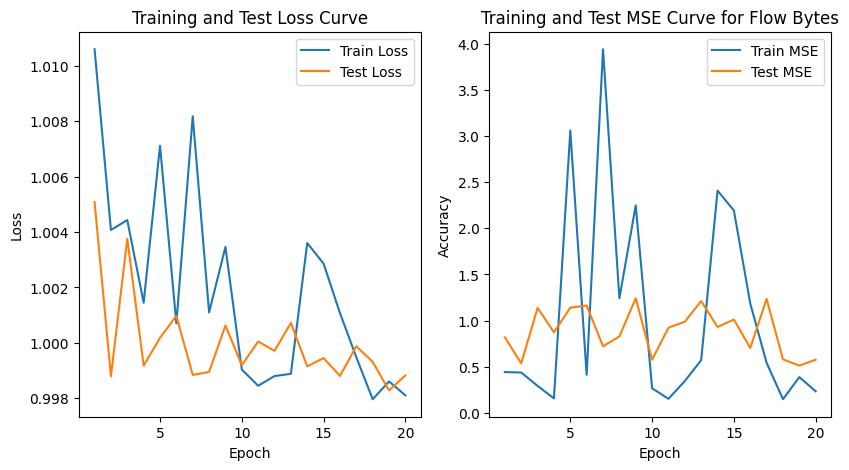

In [273]:
epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies =  []

for t in range(epochs):
  train_loss, train_mse= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_mse = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  # Training metrics 
  train_losses.append(train_loss)
  train_accuracies.append(train_mse.item())

  # Test metrics 
  test_losses.append(test_loss)
  test_accuracies.append(test_mse)

  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  # print(train_accuracies[0])
  train_metrics = f"Train: Loss {format_metric(train_loss)},  MSE {format_metric(train_mse)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)},  MSE  {format_metric(test_mse)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 3, 2)
# print(train_accuracies_1.dtype)
plt.plot(range(1, epochs+1), train_accuracies, label='Train MSE')
plt.plot(range(1, epochs+1), test_accuracies, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test MSE Curve for Flow Bytes')
plt.legend()


weird loss. Going to make sure that the mlp_sclale classification is helping

Epoch [ 1/20]        | Train: Loss 1.19950,  MSE 0.57795                                 | Test: Loss 1.19958,  MSE  0.79775
Epoch [ 2/20]        | Train: Loss 1.20043,  MSE 1.10296                                 | Test: Loss 1.20027,  MSE  1.33974
Epoch [ 3/20]        | Train: Loss 1.19941,  MSE 0.55123                                 | Test: Loss 1.20040,  MSE  1.09270
Epoch [ 4/20]        | Train: Loss 1.19925,  MSE 0.54835                                 | Test: Loss 1.19882,  MSE  0.85302
Epoch [ 5/20]        | Train: Loss 1.19915,  MSE 0.56102                                 | Test: Loss 1.19969,  MSE  1.17080
Epoch [ 6/20]        | Train: Loss 1.20115,  MSE 1.41713                                 | Test: Loss 1.20010,  MSE  1.20229
Epoch [ 7/20]        | Train: Loss 1.19866,  MSE 0.32394                                 | Test: Loss 1.20023,  MSE  1.21194
Epoch [ 8/20]        | Train: Loss 1.20008,  MSE 0.86099                                 | Test: Loss 1.20002,  MSE  1.28460


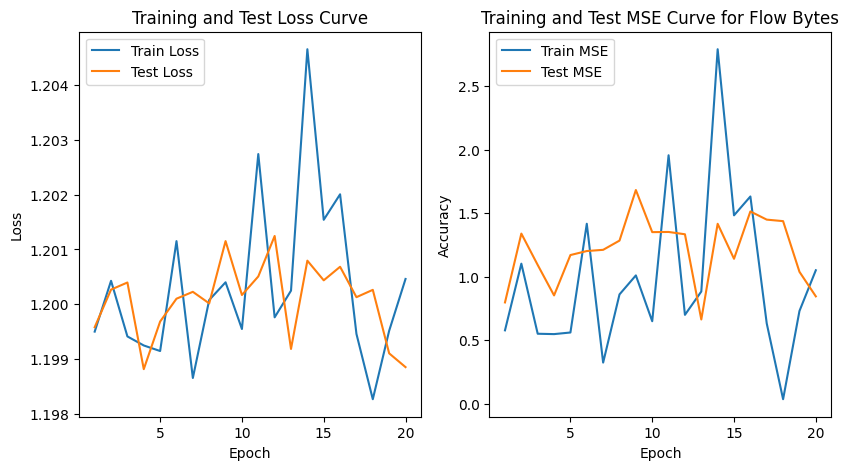

In [275]:
#Updated with f1
model = Classifier(n_cat_features=unique_classes_per_column,
                   n_cont_features=len(cont_cols)-1,
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=2, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model


epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies =  []

for t in range(epochs):
  train_loss, train_mse= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_mse = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  # Training metrics 
  train_losses.append(train_loss)
  train_accuracies.append(train_mse.item())

  # Test metrics 
  test_losses.append(test_loss)
  test_accuracies.append(test_mse)

  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  # print(train_accuracies[0])
  train_metrics = f"Train: Loss {format_metric(train_loss)},  MSE {format_metric(train_mse)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)},  MSE  {format_metric(test_mse)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 3, 2)
# print(train_accuracies_1.dtype)
plt.plot(range(1, epochs+1), train_accuracies, label='Train MSE')
plt.plot(range(1, epochs+1), test_accuracies, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test MSE Curve for Flow Bytes')
plt.legend()



makes sense that a higher more complex classifying head helps. going to test the same one with bigger lr

Epoch [ 1/20]        | Train: Loss 1.00484,  MSE 1.46196                                 | Test: Loss 0.99961,  MSE  0.93054
Epoch [ 2/20]        | Train: Loss 1.00439,  MSE 2.48415                                 | Test: Loss 1.00118,  MSE  1.64668
Epoch [ 3/20]        | Train: Loss 0.99848,  MSE 0.10004                                 | Test: Loss 0.99938,  MSE  0.79586
Epoch [ 4/20]        | Train: Loss 0.99935,  MSE 0.28083                                 | Test: Loss 1.00067,  MSE  1.38474
Epoch [ 5/20]        | Train: Loss 1.00162,  MSE 1.11679                                 | Test: Loss 1.00021,  MSE  1.18449
Epoch [ 6/20]        | Train: Loss 0.99918,  MSE 0.50011                                 | Test: Loss 1.00120,  MSE  1.34177
Epoch [ 7/20]        | Train: Loss 0.99981,  MSE 0.57742                                 | Test: Loss 0.99942,  MSE  0.80201
Epoch [ 8/20]        | Train: Loss 0.99875,  MSE 0.26883                                 | Test: Loss 1.00107,  MSE  1.45435


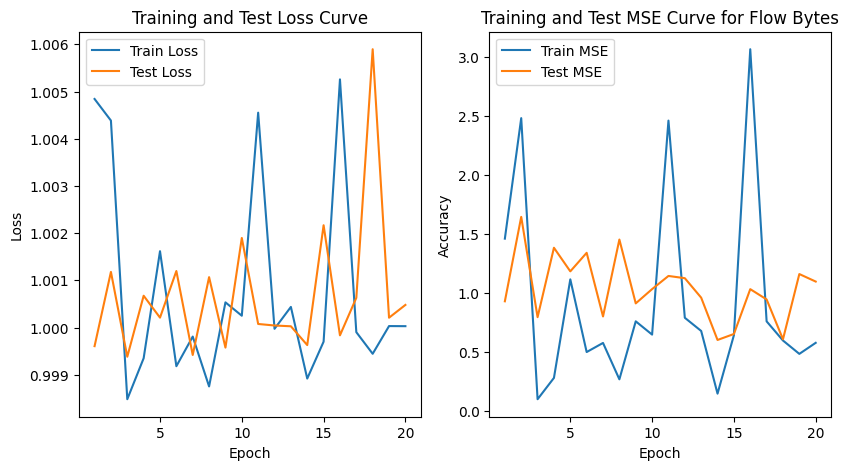

In [276]:
#Updated with f1
model = Classifier(n_cat_features=unique_classes_per_column,
                   n_cont_features=len(cont_cols)-1,
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=8, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model

optimizer = torch.optim.Adam(params=model.parameters(), lr = .01) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies =  []

for t in range(epochs):
  train_loss, train_mse= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_mse = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  # Training metrics 
  train_losses.append(train_loss)
  train_accuracies.append(train_mse.item())

  # Test metrics 
  test_losses.append(test_loss)
  test_accuracies.append(test_mse)

  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  # print(train_accuracies[0])
  train_metrics = f"Train: Loss {format_metric(train_loss)},  MSE {format_metric(train_mse)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)},  MSE  {format_metric(test_mse)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 3, 2)
# print(train_accuracies_1.dtype)
plt.plot(range(1, epochs+1), train_accuracies, label='Train MSE')
plt.plot(range(1, epochs+1), test_accuracies, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test MSE Curve for Flow Bytes')
plt.legend()



loss is still extremely inconsistent... going to try even higher lr to see more clearly

Epoch [ 1/20]        | Train: Loss 1.45726,  MSE 0.68728                                 | Test: Loss 1.00111,  MSE  1.60244
Epoch [ 2/20]        | Train: Loss 1.00158,  MSE 0.32562                                 | Test: Loss 1.00797,  MSE  1.29972
Epoch [ 3/20]        | Train: Loss 1.00320,  MSE 0.28597                                 | Test: Loss 1.00286,  MSE  1.54202
Epoch [ 4/20]        | Train: Loss 1.00551,  MSE 0.74631                                 | Test: Loss 1.01360,  MSE  0.35603
Epoch [ 5/20]        | Train: Loss 1.00870,  MSE 0.86786                                 | Test: Loss 0.99999,  MSE  1.00591
Epoch [ 6/20]        | Train: Loss 1.00618,  MSE 1.29321                                 | Test: Loss 1.00130,  MSE  1.43648
Epoch [ 7/20]        | Train: Loss 1.01896,  MSE 4.64345                                 | Test: Loss 1.00325,  MSE  0.55856
Epoch [ 8/20]        | Train: Loss 1.00316,  MSE 0.12030                                 | Test: Loss 1.00449,  MSE  1.09078


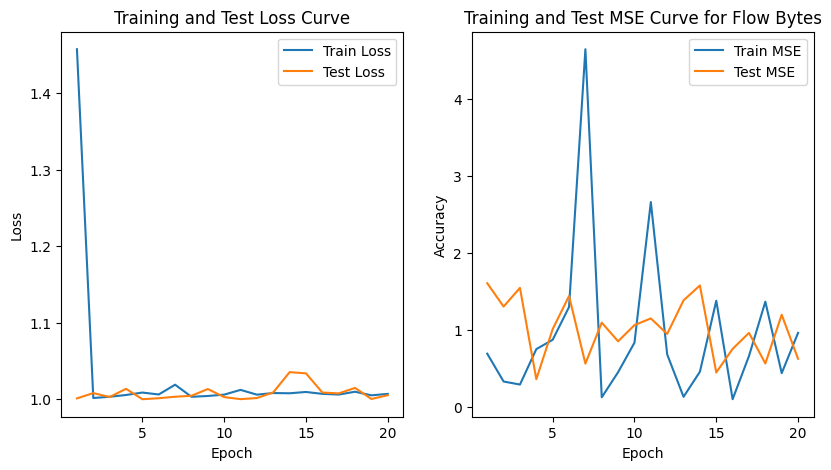

In [277]:
#Updated with f1
model = Classifier(n_cat_features=unique_classes_per_column,
                   n_cont_features=len(cont_cols)-1,
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=8, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model

optimizer = torch.optim.Adam(params=model.parameters(), lr = .1) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies =  []

for t in range(epochs):
  train_loss, train_mse= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_mse = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  # Training metrics 
  train_losses.append(train_loss)
  train_accuracies.append(train_mse.item())

  # Test metrics 
  test_losses.append(test_loss)
  test_accuracies.append(test_mse)

  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  # print(train_accuracies[0])
  train_metrics = f"Train: Loss {format_metric(train_loss)},  MSE {format_metric(train_mse)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)},  MSE  {format_metric(test_mse)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 3, 2)
# print(train_accuracies_1.dtype)
plt.plot(range(1, epochs+1), train_accuracies, label='Train MSE')
plt.plot(range(1, epochs+1), test_accuracies, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test MSE Curve for Flow Bytes')
plt.legend()



now the oposite (lower learning rate)

Epoch [ 1/20]        | Train: Loss 1.00535,  MSE 2.03861                                 | Test: Loss 1.00014,  MSE  0.86168
Epoch [ 2/20]        | Train: Loss 1.00127,  MSE 0.27127                                 | Test: Loss 0.99913,  MSE  0.68754
Epoch [ 3/20]        | Train: Loss 1.00068,  MSE 0.32585                                 | Test: Loss 1.00861,  MSE  0.89650
Epoch [ 4/20]        | Train: Loss 0.99919,  MSE 0.07414                                 | Test: Loss 1.00830,  MSE  0.86421
Epoch [ 5/20]        | Train: Loss 1.00436,  MSE 2.27582                                 | Test: Loss 0.99919,  MSE  0.71567
Epoch [ 6/20]        | Train: Loss 0.99985,  MSE 0.38246                                 | Test: Loss 1.00022,  MSE  0.98519
Epoch [ 7/20]        | Train: Loss 1.00061,  MSE 0.71327                                 | Test: Loss 0.99965,  MSE  0.77783
Epoch [ 8/20]        | Train: Loss 1.00590,  MSE 2.64473                                 | Test: Loss 0.99933,  MSE  0.81328


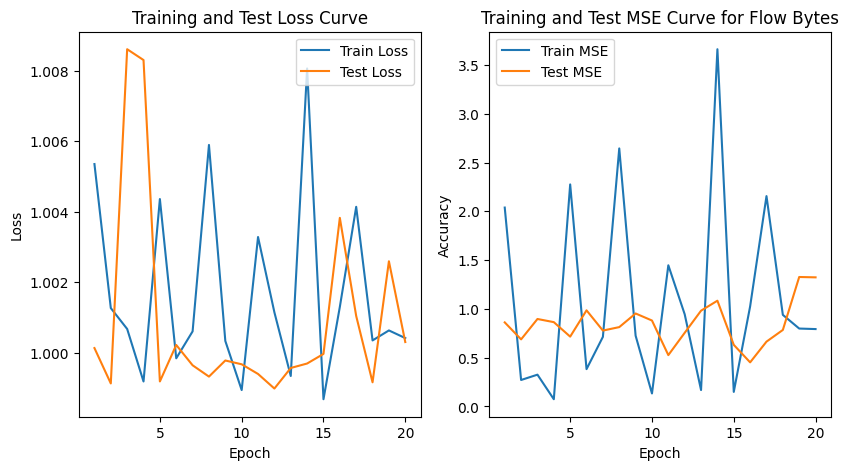

In [278]:
#Updated with f1
model = Classifier(n_cat_features=unique_classes_per_column,
                   n_cont_features=len(cont_cols)-1,
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=8, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model

optimizer = torch.optim.Adam(params=model.parameters(), lr = .0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies =  []

for t in range(epochs):
  train_loss, train_mse= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_mse = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  # Training metrics 
  train_losses.append(train_loss)
  train_accuracies.append(train_mse.item())

  # Test metrics 
  test_losses.append(test_loss)
  test_accuracies.append(test_mse)

  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  # print(train_accuracies[0])
  train_metrics = f"Train: Loss {format_metric(train_loss)},  MSE {format_metric(train_mse)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)},  MSE  {format_metric(test_mse)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 3, 2)
# print(train_accuracies_1.dtype)
plt.plot(range(1, epochs+1), train_accuracies, label='Train MSE')
plt.plot(range(1, epochs+1), test_accuracies, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test MSE Curve for Flow Bytes')
plt.legend()



Epoch [ 1/20]        | Train: Loss 1.01746,  MSE 0.00231                                 | Test: Loss 1.00634,  MSE  0.87195
Epoch [ 2/20]        | Train: Loss 1.01061,  MSE 0.56605                                 | Test: Loss 1.01649,  MSE  0.99597
Epoch [ 3/20]        | Train: Loss 1.00975,  MSE 0.25473                                 | Test: Loss 1.01474,  MSE  0.40837
Epoch [ 4/20]        | Train: Loss 1.00944,  MSE 2.75837                                 | Test: Loss 1.00031,  MSE  0.47634
Epoch [ 5/20]        | Train: Loss 1.00726,  MSE 1.00513                                 | Test: Loss 1.01202,  MSE  1.44799
Epoch [ 6/20]        | Train: Loss 1.00613,  MSE 2.80503                                 | Test: Loss 1.00027,  MSE  0.99202
Epoch [ 7/20]        | Train: Loss 1.00127,  MSE 1.06629                                 | Test: Loss 1.05191,  MSE  0.70421
Epoch [ 8/20]        | Train: Loss 1.00459,  MSE 1.09244                                 | Test: Loss 1.00208,  MSE  1.10469


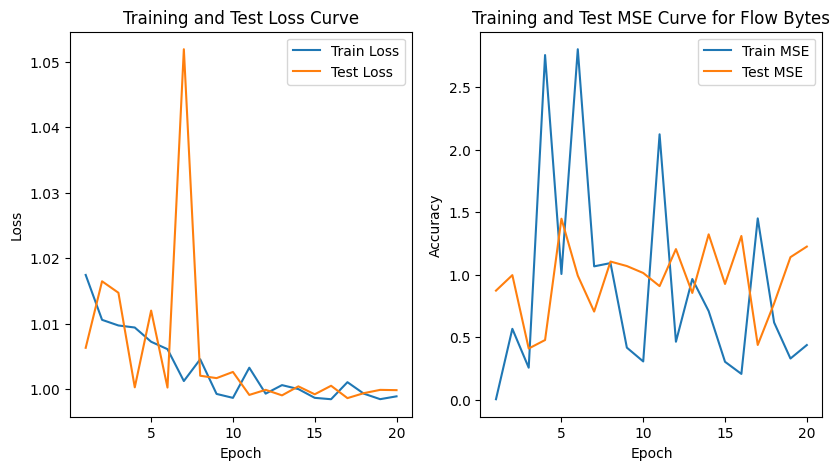

In [279]:
#Updated with f1
model = Classifier(n_cat_features=unique_classes_per_column,
                   n_cont_features=len(cont_cols)-1,
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=16, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model

optimizer = torch.optim.Adam(params=model.parameters(), lr = .001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies =  []

for t in range(epochs):
  train_loss, train_mse= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_mse = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  # Training metrics 
  train_losses.append(train_loss)
  train_accuracies.append(train_mse.item())

  # Test metrics 
  test_losses.append(test_loss)
  test_accuracies.append(test_mse)

  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  # print(train_accuracies[0])
  train_metrics = f"Train: Loss {format_metric(train_loss)},  MSE {format_metric(train_mse)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)},  MSE  {format_metric(test_mse)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 3, 2)
# print(train_accuracies_1.dtype)
plt.plot(range(1, epochs+1), train_accuracies, label='Train MSE')
plt.plot(range(1, epochs+1), test_accuracies, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test MSE Curve for Flow Bytes')
plt.legend()



Epoch [ 1/20]        | Train: Loss 1.08745,  MSE 0.63607                                 | Test: Loss 1.00098,  MSE  1.47078
Epoch [ 2/20]        | Train: Loss 0.99935,  MSE 0.61188                                 | Test: Loss 1.00082,  MSE  0.48660
Epoch [ 3/20]        | Train: Loss 0.99925,  MSE 0.36134                                 | Test: Loss 0.99907,  MSE  0.43258
Epoch [ 4/20]        | Train: Loss 0.99958,  MSE 0.44640                                 | Test: Loss 0.99868,  MSE  0.50790
Epoch [ 5/20]        | Train: Loss 0.99867,  MSE 0.17315                                 | Test: Loss 0.99955,  MSE  0.85835
Epoch [ 6/20]        | Train: Loss 1.00547,  MSE 2.93511                                 | Test: Loss 0.99984,  MSE  1.02200
Epoch [ 7/20]        | Train: Loss 1.00009,  MSE 0.61273                                 | Test: Loss 1.00101,  MSE  1.09861
Epoch [ 8/20]        | Train: Loss 0.99951,  MSE 0.47027                                 | Test: Loss 1.00049,  MSE  1.22559


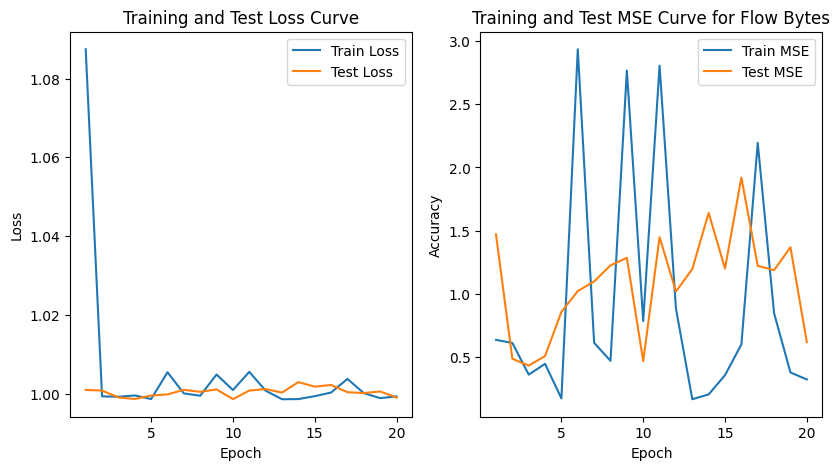

In [280]:
#Updated with f1
model = Classifier(n_cat_features=unique_classes_per_column,
                   n_cont_features=len(cont_cols)-1,
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=64, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model

optimizer = torch.optim.Adam(params=model.parameters(), lr = .01) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies =  []

for t in range(epochs):
  train_loss, train_mse= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_mse = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  # Training metrics 
  train_losses.append(train_loss)
  train_accuracies.append(train_mse.item())

  # Test metrics 
  test_losses.append(test_loss)
  test_accuracies.append(test_mse)

  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  # print(train_accuracies[0])
  train_metrics = f"Train: Loss {format_metric(train_loss)},  MSE {format_metric(train_mse)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)},  MSE  {format_metric(test_mse)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 3, 2)
# print(train_accuracies_1.dtype)
plt.plot(range(1, epochs+1), train_accuracies, label='Train MSE')
plt.plot(range(1, epochs+1), test_accuracies, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test MSE Curve for Flow Bytes')
plt.legend()



going try with similar params to ft transformer

c:\Users\prime\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\prime\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([227])) that is different to the input size (torch.Size([227, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\prime\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([247])) that is different to the input size (torch.Size([247, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have th

Epoch [ 1/20]        | Train: Loss 1.02464,  MSE 1.10841                                 | Test: Loss 1.00134,  MSE  0.93186
Epoch [ 2/20]        | Train: Loss 1.00316,  MSE 1.03314                                 | Test: Loss 1.00671,  MSE  1.08701
Epoch [ 3/20]        | Train: Loss 1.00773,  MSE 1.09580                                 | Test: Loss 1.00143,  MSE  0.99508
Epoch [ 4/20]        | Train: Loss 1.00202,  MSE 0.85754                                 | Test: Loss 1.01187,  MSE  1.05443
Epoch [ 5/20]        | Train: Loss 1.00437,  MSE 0.93630                                 | Test: Loss 1.00784,  MSE  0.92523
Epoch [ 6/20]        | Train: Loss 1.00459,  MSE 1.08213                                 | Test: Loss 1.01084,  MSE  0.93861
Epoch [ 7/20]        | Train: Loss 1.00769,  MSE 1.13435                                 | Test: Loss 0.99998,  MSE  1.02849
Epoch [ 8/20]        | Train: Loss 1.00370,  MSE 0.97726                                 | Test: Loss 1.00014,  MSE  0.95858


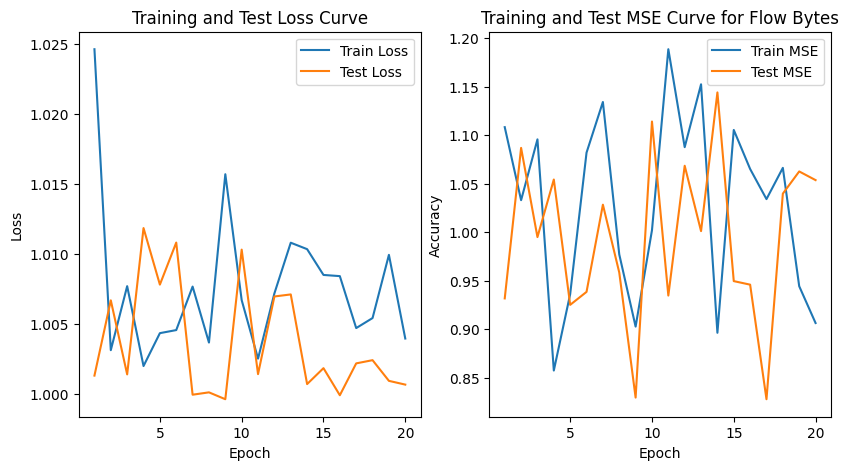

In [287]:
#Updated with f1
model = Classifier(n_cat_features=unique_classes_per_column,
                   n_cont_features=len(cont_cols)-1,
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   num_layers=3,
                                   embed_size=64,
                                   heads=8,
                                   forward_expansion=1, 
                                   mlp_scale_classification=64, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model

optimizer = torch.optim.Adam(params=model.parameters(), lr = .0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies =  []

for t in range(epochs):
  train_loss, train_mse= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_mse = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  # Training metrics 
  train_losses.append(train_loss)
  train_accuracies.append(train_mse.item())

  # Test metrics 
  test_losses.append(test_loss)
  test_accuracies.append(test_mse)

  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  # print(train_accuracies[0])
  train_metrics = f"Train: Loss {format_metric(train_loss)},  MSE {format_metric(train_mse)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)},  MSE  {format_metric(test_mse)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")



# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 3, 2)
# print(train_accuracies_1.dtype)
plt.plot(range(1, epochs+1), train_accuracies, label='Train MSE')
plt.plot(range(1, epochs+1), test_accuracies, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test MSE Curve for Flow Bytes')
plt.legend()

